<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# Проект «Анализ вакансий из HeadHunter»
   

In [61]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from pandas.core.interchange.dataframe_protocol import DataFrame
import seaborn as sns
import numpy as np

In [62]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python

# подгружаем переменные окружения из .env
load_dotenv()

# устанавливаем секреты из переменных окружения
DBNAME = os.getenv('DBNAME')
USER = os.getenv('DBUSER')
PASSWORD = os.getenv('DBPASSWORD')
HOST = os.getenv('DBHOST')
PORT = os.getenv('DBPORT')

In [63]:
import warnings

# Чтобы Pandas не сыпал SQLAlchemy Warnings
warnings.simplefilter(action='ignore', category=UserWarning)

connection = psycopg2.connect(
   dbname=DBNAME,
   user=USER,
   host=HOST,
   password=PASSWORD,
   port=PORT
)

## 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в базе (вакансии находятся в таблице `vacancies`).

In [64]:
# текст запроса
query_3_1 = f'''
SELECT COUNT(*) as cnt
FROM vacancies
'''

In [65]:
# результат запроса
df = pd.read_sql_query(query_3_1, connection)
vacancies_cnt = df['cnt'][0]
print("Количество вакансий в базе:", vacancies_cnt)

Количество вакансий в базе: 49197


2. Напишите запрос, который посчитает количество работодателей (таблица `employers`).

In [66]:
# текст запроса
q_employers = f'''
SELECT COUNT(*) as cnt
FROM employers
'''

In [67]:
# результат запроса
df = pd.read_sql_query(q_employers, connection)
employers_cnt = df['cnt'][0]
print("Количество работодателей в базе:", employers_cnt)

Количество работодателей в базе: 23501


3. Посчитайте с помощью запроса количество регионов (таблица `areas`).

In [68]:
# текст запроса
q_areas = f'''
SELECT COUNT(*) as cnt
FROM areas
'''

In [69]:
# результат запроса
df = pd.read_sql_query(q_areas, connection)
areas_cnt = df['cnt'][0]
print("Количество регионов в базе:", areas_cnt)

Количество регионов в базе: 1362


4. Посчитайте с помощью запроса количество сфер деятельности в базе (таблица `industries`).

In [70]:
# текст запроса
q_industries = f'''
SELECT COUNT(*) as cnt
FROM industries
'''

In [71]:
# результат запроса
df = pd.read_sql_query(q_industries, connection)
industries_cnt = df['cnt'][0]
print("Количество сфер деятельности в базе:", industries_cnt)

Количество сфер деятельности в базе: 294


***

In [72]:
# выводы по предварительному анализу данных

print(f'''
Итого:
- В базе вакансий {vacancies_cnt}.
- Всего работодателей {employers_cnt}.
- В базе существует {areas_cnt} регионов.
- Существует {industries_cnt} сфер деятельности.

Из интересного:
- На одного работодателя в среднем приходится {round(vacancies_cnt / employers_cnt, 2)} вакансии.
''')


Итого:
- В базе вакансий 49197.
- Всего работодателей 23501.
- В базе существует 1362 регионов.
- Существует 294 сфер деятельности.

Из интересного:
- На одного работодателя в среднем приходится 2.09 вакансии.



База весьма масштабная, а география и количество отраслей достаточно обширны, чтобы можно было проводить репрезентативные исследования и делать выводы об общем состоянии HR рынка.
Будет интересно посмотреть, как вакансии распределяются по компаниям и городам, а так же какие требования к опыту предъявляют компании и какие зарплатные вилки предлагают.

## 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (`cnt`) вакансий в каждом регионе (`area`).
Отсортируйте по количеству вакансий в порядке убывания.

In [73]:
# текст запроса
q_area_vacancies = f'''
SELECT a.name AS area, COUNT(v.*) AS cnt
FROM vacancies v
JOIN areas a ON v.area_id = a.id
GROUP BY a.name
ORDER BY cnt DESC
'''

In [74]:
# результат запроса
df = pd.read_sql_query(q_area_vacancies, connection)
df.head()

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


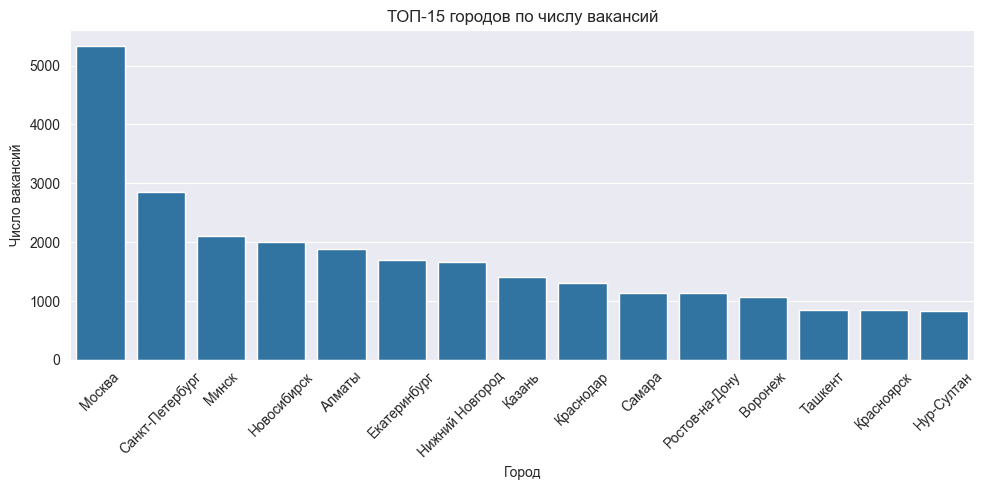

In [75]:
df_vacancies = df.head(15)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_vacancies, x="area", y="cnt")
plt.title("ТОП-15 городов по числу вакансий")
plt.xlabel("Город")
plt.ylabel("Число вакансий")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [76]:
# текст запроса
q_vacancies_not_empty = '''
SELECT COUNT(*) AS vacancy_not_empty_count
FROM vacancies
WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL;
'''

In [77]:
# результат запроса
df = pd.read_sql_query(q_vacancies_not_empty, connection)
vacancies_not_empty = df['vacancy_not_empty_count'][0]
print("Кол-во вакансий, где хотя бы одно значение вилки зарплаты заполнено:", df['vacancy_not_empty_count'][0])

Кол-во вакансий, где хотя бы одно значение вилки зарплаты заполнено: 24073


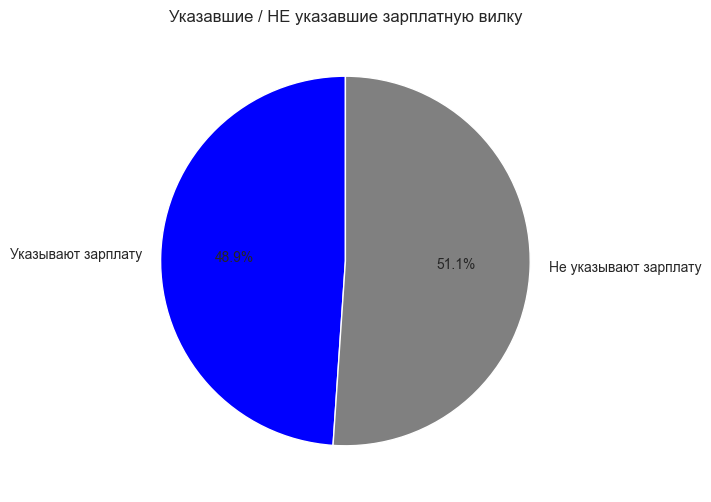

In [78]:
# Данные
labels = ['Указывают зарплату', 'Не указывают зарплату']
sizes = [vacancies_not_empty, vacancies_cnt - vacancies_not_empty]  # Доли
colors = ['blue', 'gray']  # Разные цвета

# Рисуем круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Указавшие / НЕ указавшие зарплатную вилку")
plt.show()

3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до **целого числа**.

In [79]:
# текст запроса
q_vacancies_salary_avg = '''
SELECT
    ROUND(AVG(salary_from)) AS avg_salary_from,
    ROUND(AVG(salary_to)) AS avg_salary_to
FROM vacancies
'''

In [80]:
# результат запроса
df = pd.read_sql_query(q_vacancies_salary_avg, connection)
df['avg_salary_from'] = df['avg_salary_from'].astype(int)
df['avg_salary_to'] = df['avg_salary_to'].astype(int)

avg_salary_from = df['avg_salary_from'][0]
avg_salary_to = df['avg_salary_to'][0]

df.head()

,avg_salary_from,avg_salary_to
0,71065,110537


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (`schedule`) и типа трудоустройства (`employment`), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [81]:
# текст запроса
q_schedule_employment = '''
SELECT
    schedule,
    employment,
    COUNT(*) AS vacancy_count
FROM vacancies
GROUP BY schedule, employment
ORDER BY vacancy_count DESC;
'''

In [82]:
# результат запроса
df = pd.read_sql_query(q_schedule_employment, connection)
df.head()

,schedule,employment,vacancy_count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940


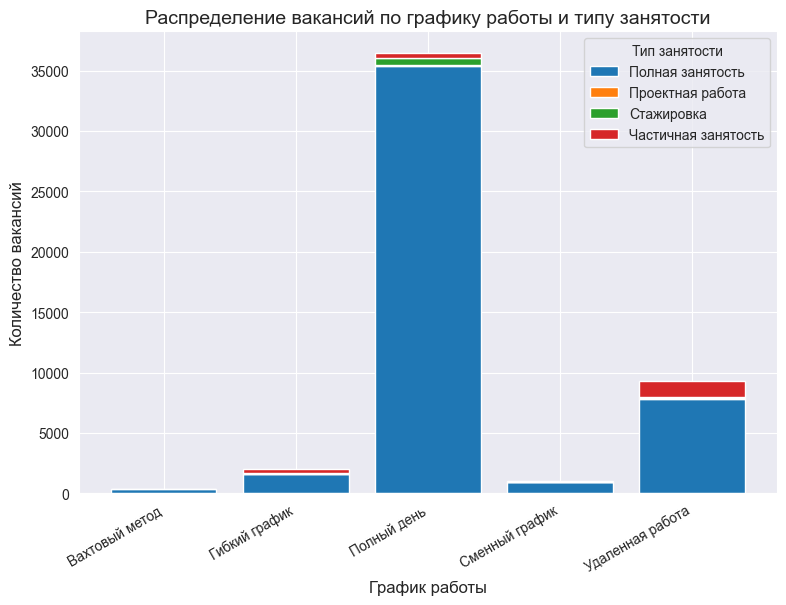

In [83]:
# Группируем данные по графику работы и типу занятости
pivot_df = df.pivot(index="schedule", columns="employment", values="vacancy_count")

# Строим составленную (stacked) столбчатую диаграмму
fig, ax = plt.subplots(figsize=(9, 6))

# Перебираем категории занятости и строим stacked bar
bottom = np.zeros(len(pivot_df))  # Для накопления значений
for column in pivot_df.columns:
    ax.bar(pivot_df.index, pivot_df[column], label=column, bottom=bottom)
    bottom += pivot_df[column].fillna(0).values  # Обновляем нижнюю границу

# Настройка осей и заголовка
ax.set_xlabel("График работы", fontsize=12)
ax.set_ylabel("Количество вакансий", fontsize=12)
ax.set_title("Распределение вакансий по графику работы и типу занятости", fontsize=14)
ax.legend(title="Тип занятости", fontsize=10)

# Отображение графика
plt.xticks(rotation=30, ha="right")
plt.show()

5. Напишите запрос, выводящий значения поля «Требуемый опыт работы» (`experience`) в порядке возрастания количества вакансий, в которых указан данный вариант опыта.

In [84]:
# текст запроса
q_experience_vacancies_cnt = '''
SELECT
    experience,
    COUNT(*) AS vacancy_count
FROM vacancies
GROUP BY experience
ORDER BY vacancy_count ASC;
'''

In [85]:
# результат запроса
df = pd.read_sql_query(q_experience_vacancies_cnt, connection)
df.head()

,experience,vacancy_count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

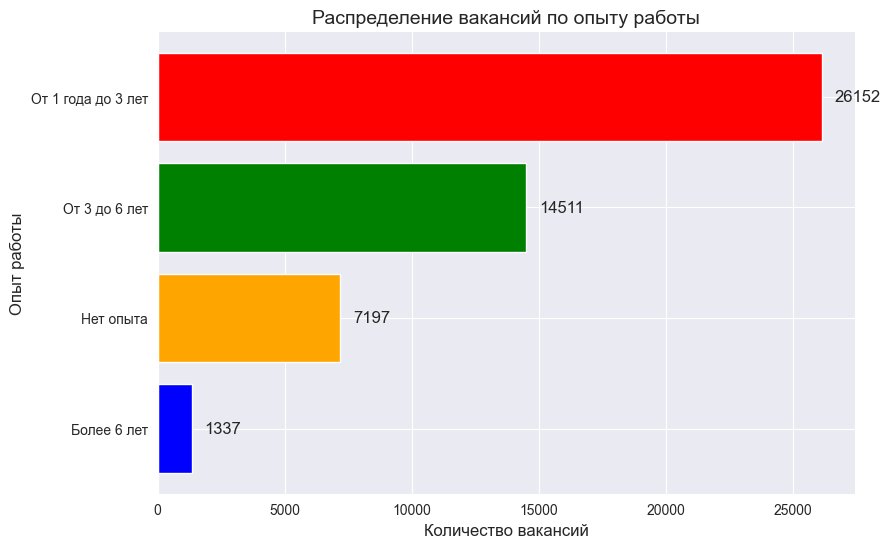

In [86]:
# Строим горизонтальную столбчатую диаграмму
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.barh(df["experience"], df["vacancy_count"], color=["blue", "orange", "green", "red"])

# Подписываем значения на графике
for bar in bars:
    width = bar.get_width()
    ax.text(width + 500, bar.get_y() + bar.get_height()/2, str(width), ha='left', va='center', fontsize=12)

# Подписываем оси
ax.set_xlabel("Количество вакансий", fontsize=12)
ax.set_ylabel("Опыт работы", fontsize=12)
ax.set_title("Распределение вакансий по опыту работы", fontsize=14)

# Убираем рамку и добавляем стиль
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Отображаем график
plt.show()

In [87]:
# выводы по детальному анализу вакансий

Ожидаемо, наибольшее количество вакансий (5333) сосредоточенно в Московском регионе. Вообще, крупные города, такие как Москва, Санкт-Петербург, Минск, Новосибирск и т.д., возглавляют рейтинг по количеству вакансий. Интересно, как распределены города-миллионники стран ближнего зарубежья (Минск, Алматы, Ташкент и т.д.). Они вполне вписываются в общую картину Российских городов. Это свидетельствует, что Head Hunter востребован так же хорошо и в странах СНГ.

Более половины вакансий не содержат никаких ориентиров по зарплате. Судя по всему, большинство работодателей предпочитает обсуждать зарплатные ожидания строго индивидуально.

Средние значения нижней и верхней границ окладов (70–110 тыс. рублей) не говорят в отрыве от динамики год - к году ни о чем. Было бы интересней посмотреть как значения отличаются от требуемого опыта, региона и отрасли.

График типа занятости и графика работы показыват, что лидирует классическая "полная занятость + полный рабочий день". Однако интересно, что порядка 20% занимает удаленный формат работы, что может свидетельствовать об изменении формата труда, если можно будет проследить изменения этих значений в динамике.

По требуемому опыту наиболее востребованные категории — 1-3 года и 3-6 лет. Позиции с требованиями опыта более 6 лет встречаются редко, даже реже вакансий "без опыта". Скорее всего, специалисты с таким опытом работы, с точки зрения работодателей в большинстве случаев эквивалентны квалификации из более популярных диапазонов, а сфера, где требуется именно такой большой, крайне ограниченна.

Для более глубокого анализа интересно провести сегментацию вакансий по отраслям и оценить, в каких именно областях наблюдается наибольший спрос.


## 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [88]:
# текст запроса
q_employers_top_1_5 = '''
-- Соберем предварительную статистику, чтобы офсетом забрать 1-е и 5-е место
WITH EmployerVacancies AS (
    SELECT
        e.name AS employer,
        COUNT(v.id) AS vacancy_count
    FROM vacancies v
    JOIN employers e ON v.employer_id = e.id
    GROUP BY e.name
    ORDER BY vacancy_count DESC
)
SELECT employer, vacancy_count
FROM EmployerVacancies
WHERE vacancy_count IN (
    (SELECT vacancy_count FROM EmployerVacancies LIMIT 1 OFFSET 0), -- 1-е место
    (SELECT vacancy_count FROM EmployerVacancies LIMIT 1 OFFSET 4)  -- 5-е место
);
'''

In [89]:
# результат запроса
df = pd.read_sql_query(q_employers_top_1_5, connection)
df.head()

,employer,vacancy_count
0,Яндекс,1933
1,Газпром нефть,331


In [104]:
# посмотрим все-таки ТОП 10 компаний по количеству вакансий
n = 10
q_top_companies = f'''
SELECT
    e.name AS employer,
    COUNT(v.id) AS vacancy_count
FROM vacancies v
JOIN employers e ON v.employer_id = e.id
GROUP BY e.name
ORDER BY vacancy_count DESC
LIMIT {n}
'''

# результат запроса
df = pd.read_sql_query(q_top_companies, connection)
df.head(n)

,employer,vacancy_count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331
5,ИК СИБИНТЕК,327
6,МТС,292
7,DataArt,247
8,Совкомбанк Технологии,204
9,Первый Бит,176


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [136]:
# ТОП регионов по количеству работодателей и вакансий
q_areas_employers_vacancies = '''
-- количество employers, сгруппированных по area_id
WITH employer_counts AS (
    SELECT area AS area_id, COUNT(id) AS employer_count
    FROM employers
    GROUP BY area
),
-- количество vacancies, сгруппированных по area_id
vacancy_counts AS (
    SELECT area_id, COUNT(id) AS vacancy_count
    FROM vacancies
    GROUP BY area_id
),
-- витрина с объединенными статистиками для выборки
region_data AS (
    SELECT
        a.name AS region,
        COALESCE(ec.employer_count, 0) AS employer_count,
        COALESCE(vc.vacancy_count, 0) AS vacancy_count
    FROM areas a
    LEFT JOIN employer_counts ec ON a.id = ec.area_id
    LEFT JOIN vacancy_counts vc ON a.id = vc.area_id
)
-- топ 10 регионов с количеством работодателей и вакансий
SELECT * FROM region_data
ORDER BY vacancy_count DESC, employer_count DESC
LIMIT 15;
'''

df_all = pd.read_sql_query(q_areas_employers_vacancies, connection)
df_all


,region,employer_count,vacancy_count
0,Москва,5864,5333
1,Санкт-Петербург,2217,2851
2,Минск,1115,2112
3,Новосибирск,573,2006
4,Алматы,721,1892
5,Екатеринбург,609,1698
6,Нижний Новгород,426,1670
7,Казань,480,1415
8,Краснодар,409,1301
9,Самара,315,1144


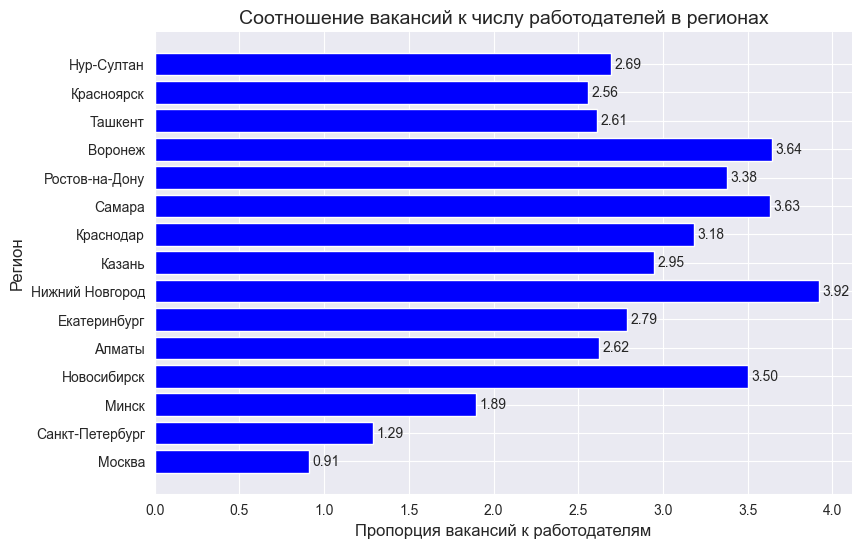

In [138]:
df_all["prop"] = df_all["vacancy_count"] / df_all["employer_count"]
# Строим горизонтальную столбчатую диаграмму для пропорции
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.barh(df_all["region"], df_all["prop"], color="blue")

# Подписываем значения на графике
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2f}", ha='left', va='center', fontsize=10)

# Подписываем оси
ax.set_xlabel("Пропорция вакансий к работодателям", fontsize=12)
ax.set_ylabel("Регион", fontsize=12)
ax.set_title("Соотношение вакансий к числу работодателей в регионах", fontsize=14)

# Убираем рамку сверху и справа
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Отображаем график
plt.show()

In [139]:
q_area_no_vacancies_max_employers = '''
SELECT a.name AS area, COUNT(DISTINCT e.id) AS employer_count
FROM areas a
LEFT JOIN employers e ON a.id = e.area
LEFT JOIN vacancies v ON a.id = v.area_id
WHERE v.id IS NULL
GROUP BY a.name
ORDER BY employer_count DESC
LIMIT 1;
'''

# результат запроса
df = pd.read_sql_query(q_area_no_vacancies_max_employers, connection)
df.head()

,area,employer_count
0,Россия,410


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [110]:
# текст запроса
q_employers_areas_count = '''
SELECT
    e.name AS employer,
    COUNT(DISTINCT v.area_id) AS region_count
FROM employers e
JOIN vacancies v ON e.id = v.employer_id
GROUP BY e.name
ORDER BY region_count DESC;
'''


In [111]:
# результат запроса
df = pd.read_sql_query(q_employers_areas_count, connection)
df.head()

,employer,region_count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности.

In [35]:
# текст запроса
q_employers_no_industry = '''
SELECT COUNT(*) AS employer_count
FROM employers e
LEFT JOIN employers_industries ei ON e.id = ei.employer_id
WHERE ei.industry_id IS NULL;
'''

In [36]:
# результат запроса
df = pd.read_sql_query(q_employers_no_industry, connection)
df.head()

,employer_count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности.

In [37]:
# текст запроса
q_employer_4_industries = '''
SELECT e.name
FROM employers e
JOIN employers_industries ei ON e.id = ei.employer_id
GROUP BY e.name
HAVING COUNT(ei.industry_id) = 4
ORDER BY e.name
LIMIT 1 OFFSET 2;
'''

In [38]:
# результат запроса
df = pd.read_sql_query(q_employer_4_industries, connection)
df.head()

,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана «Разработка программного обеспечения».


In [39]:
# текст запроса
q_employers_from_dev_cnt = '''
SELECT COUNT(DISTINCT ei.employer_id) AS employer_count
FROM employers_industries ei
JOIN industries i ON ei.industry_id = i.id
WHERE i.name = 'Разработка программного обеспечения';
'''

In [40]:
# результат запроса
df = pd.read_sql_query(q_employers_from_dev_cnt, connection)
df.head()

,employer_count
0,3553


7. Для компании «Яндекс» выведите список [городов-миллионников](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку "Total" с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

    Если возникнут трудности с этим заданием, посмотрите материалы модуля 6.4 «Как получать данные из веб-источников и API».

In [115]:
# код для получения списка городов-милионников
import requests
from bs4 import BeautifulSoup

# получение списка городов-милионников с Wikipedia
res = requests.get('https://ru.wikipedia.org/wiki/Города-миллионеры_России')
page=BeautifulSoup(res.text, 'html.parser')

# извлечение городов из таблицы на странице
cities_raw = str(page.find('table', class_="standard")).split('title="')[3:]
cities=[]

# извлечение городов из текста
for el in cities_raw:
    cities.append(el.split('">')[0])

tuple(cities)

('Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Красноярск',
 'Нижний Новгород',
 'Челябинск',
 'Уфа',
 'Самара',
 'Ростов-на-Дону',
 'Краснодар',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград')

In [126]:
# текст запроса
q_yandex = f'''

-- Подсчет статистики вакансий для Яндекса в cities
WITH YandexVacancies AS (
    SELECT
        a.name AS city,
        COUNT(v.id) AS vacancy_count
    FROM vacancies v
    JOIN employers e ON v.employer_id = e.id
    JOIN areas a ON v.area_id = a.id
    WHERE e.name = 'Яндекс'
        AND a.name IN {tuple(cities)}
    GROUP BY a.name
)

-- Выбираем по городам
SELECT city, vacancy_count FROM YandexVacancies

-- Добавляем Total в конец результата
UNION ALL

-- Суммируем для Total, чтобы вывести общее количество вакансий Яндекса
SELECT 'Total', SUM(vacancy_count) FROM YandexVacancies
ORDER BY vacancy_count ASC;
'''

In [127]:
# результат запроса
df = pd.read_sql_query(q_yandex, connection)
df

,city,vacancy_count
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Пермь,25.0
5,Казань,25.0
6,Ростов-на-Дону,25.0
7,Самара,26.0
8,Уфа,26.0
9,Краснодар,30.0


***

In [44]:
# выводы по анализу работодателей

Ожидаемо, крупные корпорации, такие как "Яндекс", "Ростелеком", "Тинькофф" и прочие значительно опережают других работодателей по числу вакансий. Это отражает не только масштаб их деятельности, но и высокую потребность в новых сотрудниках.

Интересная таблица по ТОПу 15 регионов по количеству работодателей и вакансий. Если построить график пропорции количества вакансий к количеству работодателей, то видно, что пропорция отличается в разы от региона к региону. В Москве, например, из ТОП 15 городов по вакансиям, вообще самая низкая пропорция. Там на одну компанию приходится 0.91 вакансий. Такая картина может свидетельствовать о том, что в некоторых регионах часть позиций могут стабильно размещать на других площадках. Тут есть зона для дополнительного исследования, например сделать разбивку в резрезе регион/должность.

Анализ вакансий «Яндекса» в городах-миллионниках показывает, что компания представлена во всех городах-миллионниках, либо же активно нанимает на "удаленку" во всех регионах по России. Здесь можно посмотреть на долю вакансий с удаленной занятостью.

## 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

    Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова `'data'` или `'данн'`.

    *Обратите внимание, что названия вакансий могут быть написаны в любом регистре.*


In [151]:
# текст запроса
q_relation_to_data = f'''
SELECT COUNT(*) AS vacancy_count
FROM vacancies
WHERE name ILIKE '%data%' OR name ILIKE '%данн%';
'''

In [152]:
# результат запроса
df = pd.read_sql_query(q_relation_to_data, connection)
df.head()

,vacancy_count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
    * 'data scientist'
    * 'data science'
    * 'исследователь данных'
    * 'ML' (здесь не нужно брать вакансии по HTML)
    * 'machine learning'
    * 'машинн%обучен%'

    **В следующих заданиях мы продолжим работать с вакансиями по этому условию.**

    Считаем вакансиями для специалистов уровня Junior следующие:
    + в названии есть слово “junior” **или**
    + требуемый опыт — «Нет опыта» **или**
    + тип трудоустройства — «Стажировка».


In [149]:
# текст запроса
q_affordable_junior_vacancies = f'''
SELECT COUNT(*) AS junior_ds_vacancy_count
FROM vacancies
WHERE
   -- Все, что связано с DS и ML
   (
      name ILIKE '%data scientist%'
      OR name ILIKE '%data science%'
      OR name ILIKE '%исследователь данных%'
      OR (
         name ILIKE '%ML%' AND name NOT ILIKE '%html%'
      )
      OR name ILIKE '%machine learning%'
      OR name ILIKE '%машинн%обучен%'
   )

    -- Фильтруем по критериям для Junior
    AND (
        name ILIKE '%junior%'
        OR experience = 'Нет опыта'
        OR employment = 'Стажировка'
    );
'''

In [150]:
# результат запроса
df = pd.read_sql_query(q_affordable_junior_vacancies, connection)
df.head()

,junior_ds_vacancy_count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или Postgres?

    *Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [155]:
# текст запроса
q_affordable_sql_vacancies = f'''
SELECT COUNT(*) AS ds_vacancies_with_sql
FROM vacancies
WHERE
   -- Все, что связано с DS и ML
   (
      name ILIKE '%data scientist%'
      OR name ILIKE '%data science%'
      OR name ILIKE '%исследователь данных%'
      OR (
         name ILIKE '%ML%' AND name NOT ILIKE '%html%'
      )
      OR name ILIKE '%machine learning%'
      OR name ILIKE '%машинн%обучен%'
   )

    -- Фильтр по ключевым навыкам (SQL или Postgres)
    AND (key_skills ILIKE '%sql%'
    OR key_skills ILIKE '%postgres%');
'''

In [156]:
# результат запроса
df = pd.read_sql_query(q_affordable_sql_vacancies, connection)
df.head()

,ds_vacancies_with_sql
0,229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

    *Это можно сделать помощью запроса, аналогичного предыдущему.*

In [143]:
# текст запроса
q_affordable_python_vacancies = f'''
SELECT COUNT(*) AS ds_vacancies_with_python
FROM vacancies
WHERE
   -- Все, что связано с DS и ML
   (
      name ILIKE '%data scientist%'
      OR name ILIKE '%data science%'
      OR name ILIKE '%исследователь данных%'
      OR (
         name ILIKE '%ML%' AND name NOT ILIKE '%html%'
      )
      OR name ILIKE '%machine learning%'
      OR name ILIKE '%машинн%обучен%'
   )

    -- Фильтр по ключевому навыку Python
    AND key_skills ILIKE '%python%';
'''

In [144]:
# результат запроса
df = pd.read_sql_query(q_affordable_python_vacancies, connection)
df.head()

,ds_vacancies_with_python
0,357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до **двух знаков после точки-разделителя**.

In [53]:
# текст запроса
q_key_skills = f'''
SELECT
   ROUND(AVG(LENGTH(key_skills) - LENGTH(REPLACE(key_skills, CHR(9), '')) + 1), 2) as avg_key_skills
FROM public.vacancies
WHERE
   -- Все, что связано с DS и ML
   (
      name ILIKE '%data scientist%'
      OR name ILIKE '%data science%'
      OR name ILIKE '%исследователь данных%'
      OR (
         name LIKE '%ML%' AND name NOT ILIKE '%html%'
      )
      OR name ILIKE '%machine learning%'
      OR name ILIKE '%машинн%обучен%'
   )
   -- не берем в расчет key_skills с пустыми и NULL key_skills
   AND key_skills IS NOT NULL AND key_skills != '';
'''

In [54]:
# результат запроса
df = pd.read_sql_query(q_key_skills, connection)
df.head()

,avg_key_skills
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в среднем указывают для каждого типа требуемого опыта (уникальное значение из поля `experience`).

    При решении задачи примите во внимание следующее:
    1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
    2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
    3. Если в расчётах участвует `null`, в результате он тоже даст `null` (посмотрите, что возвращает запрос `select 1 + null`). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит `null` на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

    Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до **целого числа**.

In [55]:
# текст запроса
q_avg_salary = f'''
SELECT
   experience,
   ROUND(avg(COALESCE((salary_to + salary_from)/2, salary_from, salary_to)), 0) AS avg_salary
FROM vacancies
WHERE
-- Все, что связано с DS и ML
(
   name ILIKE '%data scientist%'
   OR name ILIKE '%data science%'
   OR name ILIKE '%исследователь данных%'
   OR (
      name LIKE '%ML%' AND name NOT ILIKE '%html%'
   )
   OR name ILIKE '%machine learning%'
   OR name ILIKE '%машинн%обучен%'
)
-- Уберем полные пропуски по всему salary
AND (salary_from is not null OR salary_to is not null)

GROUP BY experience
'''

In [56]:
# результат запроса
df = pd.read_sql_query(q_avg_salary, connection)
df.head()

,experience,avg_salary
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


***

In [57]:
# выводы по предметному анализу

Количество вакансий, связанных с DS, составляет 1771. Спрос вроде как есть, но сказать, растет он или нет, не возможно. Надо смотреть в динамике,

Очень мало предложений для Junior Data Scientist. Это может свидетельствовать о высокой конкуренции на старте. Большинство предпочитают опытных кандидатов.

Знание SQL/Postgres и Python встречается часто, но, почему-то не в большинстве объявлений о найме. Это прямо странно. Возможно работодатели считают это must have навыками и указывают не всегда в таких общих формулировках. Еще возможно, что пишут в "теле" вакансии. Здесь нужно дополнительное исследование по частоте ключевых фраз по всем текстам.

Среднее количество требований к навыкам составляет 6–7, что говорит о необходимости широкой компетенции в смежных технологиях.

Уровень оплаты труда напрямую зависит от опыта: кандидаты с 3–6 годами стажа получают значительно более высокие предложения по сравнению с начинающими специалистами.

## Общий вывод по проекту

In [58]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования

### География и масштаб исследования

- Исследование охватило более 49 тысяч вакансий и 20 тысяч работодателей в 1300+ регионах, что позволяет делать репрезентативные выводы о текущем состоянии рынка труда.
Вакансии распределены по широкому спектру отраслей (около 300 сфер деятельности) — от IT и финансового сектора до образования и производства.

- Ожидаемо, основной объем вакансий сосредоточен в крупнейших городах. Лидируют Москва, Санкт-Петербург, Минск, Новосибирск, однако в некоторых регионах предложение минимально или вовсе отсутствует, несмотря на наличие работодателей. Интересно, что города СНГ (Минск, Алматы, Ташкент) по динамике схожи с российскими миллионниками, что подтверждает востребованность платформы HeadHunter в странах ближнего зарубежья.

### Распределение вакансий и зарплат

- На рынке явно преобладают вакансии с полной занятостью и стандартным графиком работы. Однако около 20% предложений предполагают удалённую работу, что может говорить о постепенном изменении формата труда.

- Более половины вакансий не содержат зарплатных ориентиров, что делает сложнее анализ рынка для кандидатов. Средние границы окладов (70–110 тыс. рублей) сами по себе малоинформативны — важнее изучить динамику по годам, а также влияние таких факторов, как опыт, регион и отрасль.

- Пропорция количества вакансий к числу работодателей значительно различается в зависимости от региона. В Москве, например, этот показатель один из самых низких (0.91 вакансий на компанию). Возможно, в разных регионах работодатели используют дополнительные платформы для найма, что может стать темой для дальнейшего исследования.

### Требования к кандидатам

- Наибольший спрос наблюдается на специалистов с 1–3 годами и 3–6 годами опыта. Интересно, что позиции без опыта встречаются чаще, чем вакансии для кандидатов с опытом более 6 лет. Вероятно, работодатели рассматривают специалистов с 6+ годами стажа в тех же категориях, что и соискателей 3–6 лет.

- Среднее количество указанных ключевых навыков — 6–7, что свидетельствует о необходимости владения сразу несколькими инструментами. В IT и аналитике это особенно заметно: кандидаты должны сочетать знания статистики, программирования и визуализации данных.

### Лидеры среди работодателей

- Крупные компании, такие как Яндекс, Сбер, Тинькофф и Ростелеком, значительно опережают других работодателей по числу вакансий. Это связано не только с масштабами их бизнеса, но и с постоянной потребностью в новых сотрудниках.

- «Яндекс» представлен практически во всех городах-миллионниках либо активно нанимает сотрудников на удалённую работу по всей России. Здесь интересно проанализировать долю удалённых вакансий в динамике.

### Спрос на Data Science-специалистов

- Общее число вакансий в сфере Data Science превышает 1,700, однако сказать, растёт ли этот рынок, невозможно без анализа динамики.

- Количество вакансий для Junior Data Scientist крайне мало, что может указывать на высокую конкуренцию среди новичков. Работодатели чаще предпочитают кандидатов с опытом, способных сразу решать практические задачи.

Знание SQL/Postgres и Python встречается во многих вакансиях. Возможно, работодатели считают эти навыки стандартными для DS и не всегда фиксируют их в блоке ключевых требований. Для более точного понимания можно исследовать тексты вакансий на частоту упоминания нужных технологий.

### Перспективные направления исследования

🔹 Детальный анализ вакансий по отраслям, чтобы выявить, в каких сферах самый большой кадровый дефицит.
🔹 Изучение динамики вакансий (если есть данные по времени публикации), чтобы определить тренды.
🔹 Кросс-анализ навыков: какие стеки технологий (Python+SQL, R+Spark) чаще встречаются вместе.
🔹 Сравнение зарплат и требований по уровням опыта (не только в DS, но и в IT, аналитике, разработке).


## Дополнительное исследование
### Топ ключевых навыков, встречающихся в вакансиях для сфера Data Science

In [157]:
# SQL-запрос для получения топ-скиллов, требуемых Data Scientists
q_top_skills = f'''
SELECT
   UNNEST(STRING_TO_ARRAY(key_skills, CHR(9))) AS skill,
   COUNT(*) AS skill_count
FROM public.vacancies
WHERE
   -- Фильтр по вакансиям в DS и ML
   (
      name ILIKE '%data scientist%'
      OR name ILIKE '%data science%'
      OR name ILIKE '%исследователь данных%'
      OR (name LIKE '%ML%' AND name NOT ILIKE '%html%')
      OR name ILIKE '%machine learning%'
      OR name ILIKE '%машинн%обучен%'
   )
   -- Исключаем пустые и NULL значения key_skills
   AND key_skills IS NOT NULL AND key_skills != ''
GROUP BY skill
ORDER BY skill_count DESC
LIMIT 15;
'''

df_skills = pd.read_sql_query(q_top_skills, connection)
df_skills.head()

,skill,skill_count
0,Python,348
1,SQL,191
2,Machine Learning,114
3,Git,66
4,Математическая статистика,62


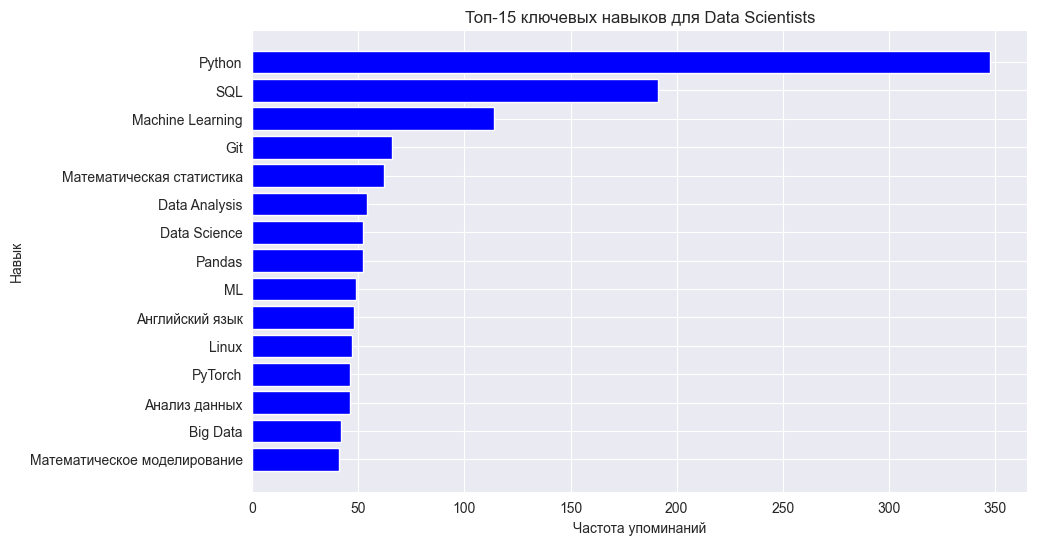

In [158]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.barh(df_skills["skill"], df_skills["skill_count"], color="blue")
plt.xlabel("Частота упоминаний")
plt.ylabel("Навык")
plt.title("Топ-15 ключевых навыков для Data Scientists")
plt.gca().invert_yaxis()  # Инвертируем ось Y для лучшей читаемости
plt.show()

### Выводы по анализу ключевых навыков Data Scientists
1. Python и SQL — базовые навыки для Data Science
    - Python лидирует с наибольшей частотой упоминаний, что подтверждает его ключевую роль в анализе данных, машинном обучении и разработке моделей.
    - SQL занимает второе место, что подчёркивает важность работы с базами данных и написания запросов для анализа данных.
2. Востребованность Machine Learning и связанных инструментов
    - Machine Learning уверенно занимает третью позицию, что ожидаемо для DS-специализации.
    - Pandas, PyTorch, ML, Data Science, Data Analysis также входят в топ, указывая на необходимость работы с данными, анализа и создания моделей.
3. Общие навыки и инструменты
    - Git среди топ-скиллов показывает, что Data Scientists должны владеть системами контроля версий.
    - Linux присутствует в списке, что говорит о востребованности работы в серверных средах.
4. Математика и статистика остаются важными
    - Математическая статистика и математическое моделирование указывают, что фундаментальные знания статистики и методов анализа данных по-прежнему важны.
5. Big Data и Cloud начинают набирать вес
    - Big Data подтверждает, что работа с большими объёмами данных становится всё более значимой.

#### В сухом остатке
Востребованный Data Scientist — это специалист, владеющий Python, SQL, ML, статистикой и инструментами работы с данными. Важно не только программирование, но и знание анализа данных, машинного обучения и работы с большими данными.

In [59]:
connection.close()